In [2]:
# Import necessary libraries
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import tensorflow as tf  # Import TensorFlow
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from IPython import display

In [3]:
# Loading & Preprocess MNIST Dataset.
# MNIST dataset contains 60,000 training images of handwritten digits.
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
train_images.shape[0]

60000

In [6]:
# Reshape to add channels dimension. since mnist is grey scale images so 1 will added as single channel dimension.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")

# Reshape to add channels dimension and normalize pixels values to -1 & 1.
train_images = (train_images - 127.5) / 127.5
print(train_images.shape)

(60000, 28, 28, 1)


In [7]:
# Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.
BUFFER_SIZE = 60000 # size of the dataset.
BATCH_SIZE = 256

# shuffling the images.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **Building the `Generator Model`.**

In [8]:
# Function to build the generator model.

def generator_model():

    model = Sequential([

        # 1st layer: Dense Layer to project the input noise vector (latent space) to a higher-dimensional space.
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100, )),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Reshape the output to a 7x7x256 tensor.
        layers.Reshape((7, 7, 256)), # the output shape will be like (batch_size, 7, 7, 256)

        # First Transposed Convolution layer.
        # Upsampling the input to a larger featured map.
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),  # output shape: (batch_size, 7, 7, 128)
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Second Transposed Convolutional Layer.
        # Upsamples to 14x14.
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Final Transposed convolutional Layer.
        # Upsamples to 28x28, matches the MNIST image size.
        # tanh activation scales the output to [-1, 1]
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh")
        # If we haven't implemented the `tanh` activation function then we would have to normalized before passing into discriminator.
        # tanh activation function deals with negative values more efficiently and bring the values in range of -1 to 1.
    ])

    return model

In [9]:
# Instantiate the generator model.
generator = generator_model()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

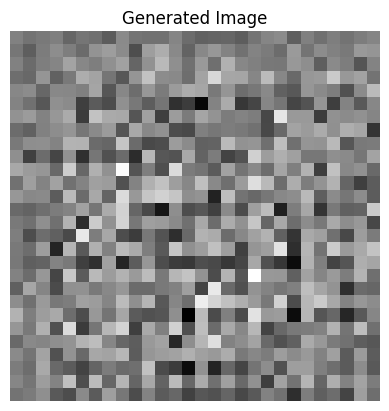

In [10]:
# Generate random latent vector and visualize it.
noise = tf.random.normal([1, 100]) # Generate random noise vector.
# print(noise)

# Passing the noise into the generator model to generate the image from the noise.
generated_image = generator(noise, training=False)

# Display the generated image.
plt.imshow(generated_image[0, :, :, 0], cmap="gray")
plt.title("Generated Image")
plt.axis("off")
plt.show()

## **Building the `Discriminator Model`.**

In [11]:
# Function to build the discriminator model.
def discriminator_model():
    model = Sequential([

        # 1st Convolutional Layer.
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        # Dropout helps to prevent overfitting by randomly setting inputs to zero during training.
        layers.Dropout(0.3),

        # 2nd Convolutional Layer.
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(), # LeakReLU allows a negative section to have a smaller gradients value instead of being completely zero. so helps to reduce the overfitting in neural networks.
        layers.Dropout(0.3),

        # Flatten the output and add a final dense layer for classification.
        layers.Flatten(),
        layers.Dense(1) # No activation function because, we have only one output either real or fake images.so.

    ])

    return model

In [12]:
# Instantisate discriminator model.
discriminator = discriminator_model()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator always takes two images:

- Generated Images from generator.

- Real Images from dataset.

In [13]:
# Let's test the discriminator on the generated image.
test_discriminator = discriminator(generated_image)
print("Discriminator Output: ", test_discriminator)

Discriminator Output:  tf.Tensor([[-0.00137647]], shape=(1, 1), dtype=float32)


In [14]:
# Defining the Loss function.
# Binary crossentropy Loss is used since we have a binary classification problem (real or fake).
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
cross_entropy

<LossFunctionWrapper(<function binary_crossentropy at 0x796ed08d7e20>, kwargs={'from_logits': True, 'label_smoothing': 0.0, 'axis': -1})>

## **Discrminator Loss**

`Discriminator` contains both the types of the loss like `real loss` and `fake loss`.




In [16]:
'''
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) image to an array of 0s.

- Pass real images and calculate loss. i.e., real loss labeled as 1.
- Pass fake images and calculate loss. i.e., fake loss labeled as 0.
'''

# Discriminator loss function.
def discriminator_loss(real_output, fake_output):

    # calculate the loss on real images and classified as 1.
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # calculate the loss on fake images and classified as 0.
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Total discriminator loss.
    total_loss = real_loss + fake_loss

    return total_loss

## **Generator Loss.**


In [17]:
'''
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or classified as 1.).
Here, compare the discriminator decisions on the generated images to an array of 1s.

* Discriminator (effectively classify both).
    - real - class 1.
    - fake - class 0
    - Total loss - fake loss + real loss.
'''
# Generate loss function.
def generator_loss(fake_output):

    # Generator tries to fool the discriminator, so we want the fake images to be classified as real (1).

    return cross_entropy(tf.ones_like(fake_output), fake_output) # Classifying 1.

In [18]:
# Initializing the Optimizer for both generators and discriminator.
# Adam optimizer is commonly used for its adaptive learning rate and momentum.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# The reason behind using the two separately optimizers for the discriminator and generator is because we are training two neural network separately.

In [19]:
# set up checkpointing to save the models during training.
checkpoint_dir = "./training_checkpoints" # Directory to save checkpoints.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Ensure the checkpoint directories exists.
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a checkpoint object to manage all the objects to be saved.
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

# Checkpoint is basically a snapshots of working models during training process.

# set the training parameters.
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# seed for generating images to visualize progress.
# using the same seed allows us to see how the generated images evolve over time.
seed = tf.random.normal([
    num_examples_to_generate, noise_dim
])

Notes:-

- Here, we are not using model.fit because we are building the model from scratch.

- `GradientTape` --> API for forward propagation and backward propagation.


Workflow:-

* Generate bunch of random noise.

* Convert random noise into image using generator.

* Train Discriminator with real and fake images.

* Calculate the Discriminator loss.

* Calculate the generatror loss.

* Update the both generator and discriminator loss.

In [20]:
# Define the training step function.
# Use @tf.function to compile the function for faster execution.
@tf.function
def train_step(images):

    # Generate the bunch of random noise for input to the generator.
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Record Operations for automatic differentiations.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # Generate fake images from the noise.
        generated_image = generator(noise, training=True)

        # Binary cross entropy loss is used.
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Get the discriminator prediction on real and fake images.
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_image, training=True)

        # Calculate the generator loss.
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output) # Takes the fake output as input which are the discriminator prediction on fake images.


        # Calculate the discriminator loss.
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss

    # Calculate gradients for generator and discriminator.
    gradients_of_generator = gen_tape.gradient(
        gen_loss,
        generator.trainable_variables
    )

    gradients_of_discriminator = disc_tape.gradient(
        disc_loss,
        discriminator.trainable_variables
    )

    # Apply gradients to update the weights of generator and discriminator.
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

In [21]:
'''
@tf.function --> is a decorator provided by TensorFlow. It tells TensorFlow to compile the function into a graph for efficient execution. This means the function will run faster because TensorFlow can optimize it.

------------------------------------------
Putting it all Together.
1. Generate Random Noise.
2. Creates a batch of Random Noise vectors to feed into the generator.
3. Generate fake images from generator.
4. Uses the generator to create the fake images from the noise.
5. Get the Discriminator Predictions.
6. Feeds real images and fake images into the discriminator to get predictions.
7. Calculate Losses.
8. Computes the loss for both the generator and discriminator based on their performance.
9. Compute the Gradients.
10. Calculate how the weights should be adjusted to minimize the losses.
11. Update Weights.
12. Adjusts the weights of both generator and discriminator using the computed gradients and their respective optimizers.
'''

'\n@tf.function --> is a decorator provided by TensorFlow. It tells TensorFlow to compile the function into a graph for efficient execution. This means the function will run faster because TensorFlow can optimize it. \n\n------------------------------------------\nPutting it all Together. \n1. Generate Random Noise. \n2. Creates a batch of Random Noise vectors to feed into the generator. \n3. Generate fake images from generator. \n4. Uses the generator to create the fake images from the noise. \n5. Get the Discriminator Predictions. \n6. Feeds real images and fake images into the discriminator to get predictions. \n7. Calculate Losses. \n8. Computes the loss for both the generator and discriminator based on their performance. \n9. Compute the Gradients. \n10. Calculate how the weights should be adjusted to minimize the losses. \n11. Update Weights. \n12. Adjusts the weights of both generator and discriminator using the computed gradients and their respective optimizers. \n'

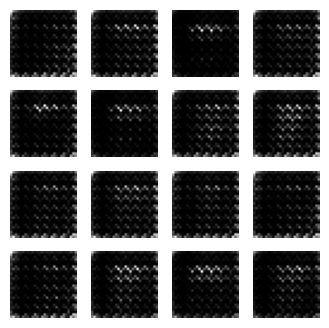

Time for epoch 1 is 21.07 sec


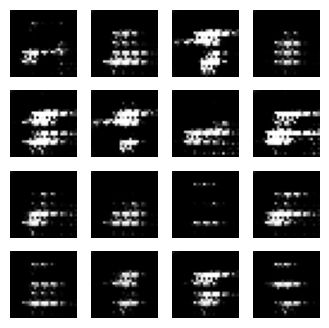

Time for epoch 2 is 13.35 sec


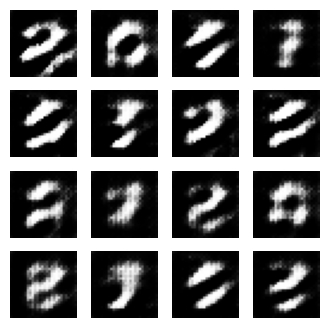

Time for epoch 3 is 13.65 sec


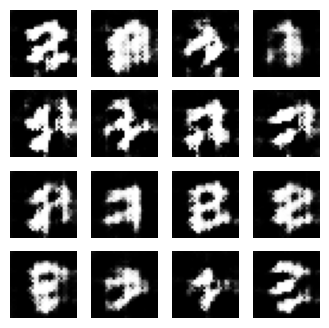

Time for epoch 4 is 14.21 sec


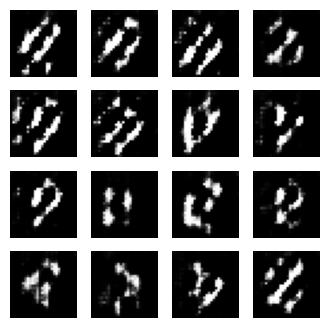

Time for epoch 5 is 13.92 sec


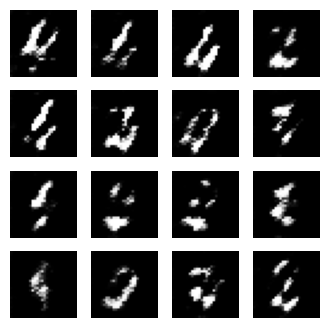

Time for epoch 6 is 13.63 sec


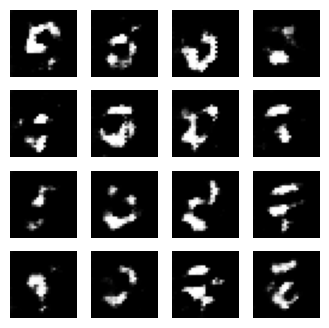

Time for epoch 7 is 13.79 sec


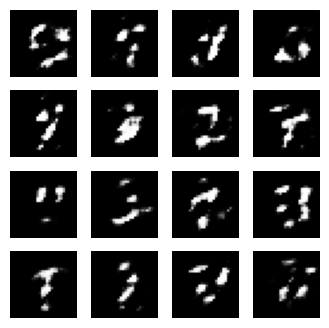

Time for epoch 8 is 13.59 sec


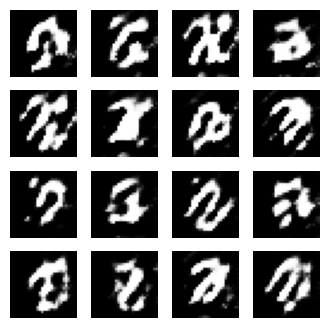

Time for epoch 9 is 13.64 sec


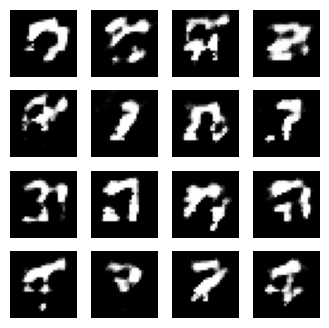

Time for epoch 10 is 13.70 sec


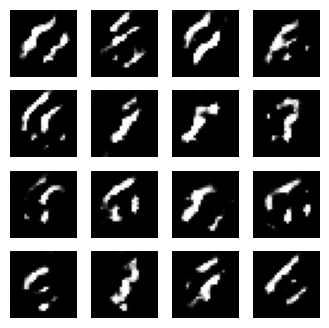

Time for epoch 11 is 13.68 sec


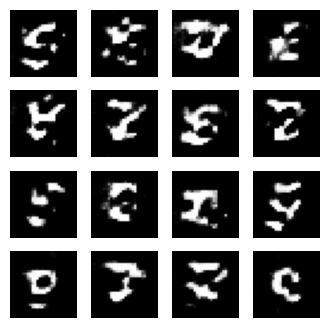

Time for epoch 12 is 13.64 sec


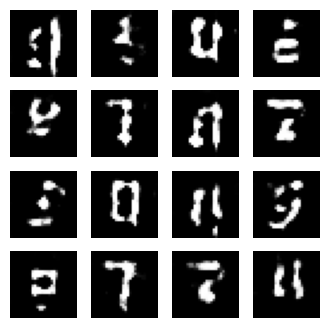

Time for epoch 13 is 13.85 sec


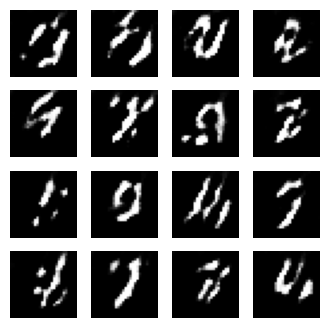

Time for epoch 14 is 13.57 sec


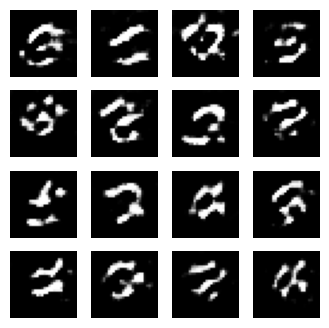

Time for epoch 15 is 14.01 sec


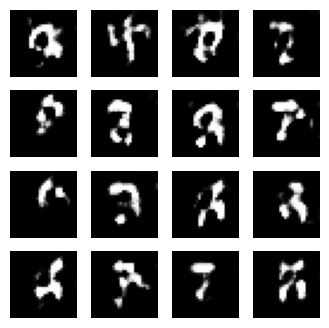

Time for epoch 16 is 13.62 sec


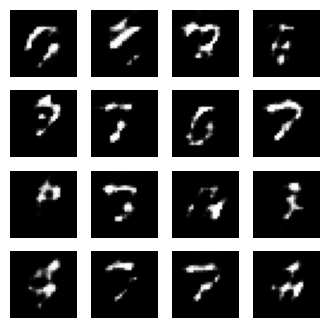

Time for epoch 17 is 13.67 sec


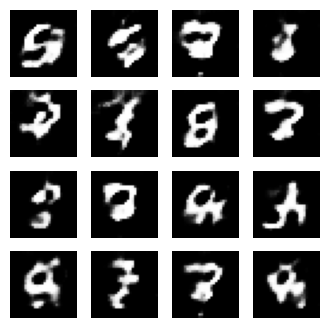

Time for epoch 18 is 13.64 sec


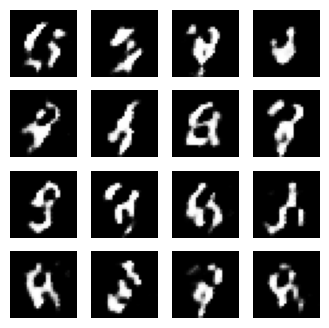

Time for epoch 19 is 13.91 sec


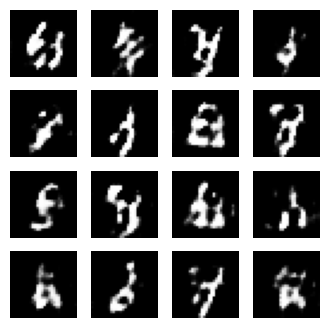

Time for epoch 20 is 13.57 sec


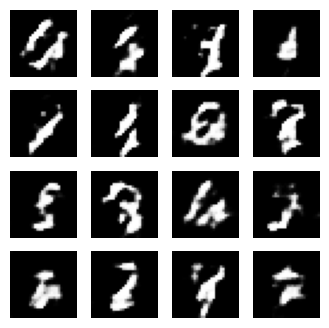

Time for epoch 21 is 13.70 sec


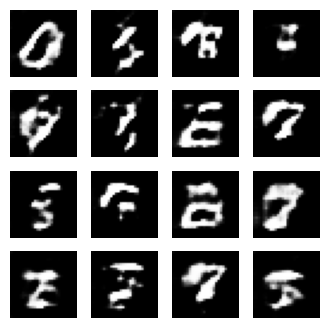

Time for epoch 22 is 13.70 sec


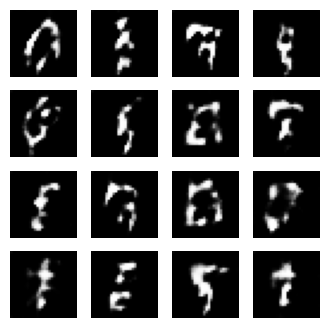

Time for epoch 23 is 13.57 sec


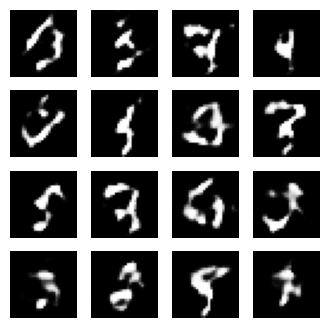

Time for epoch 24 is 13.59 sec


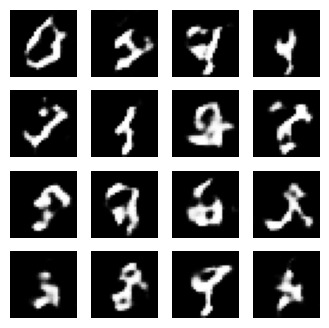

Time for epoch 25 is 13.90 sec


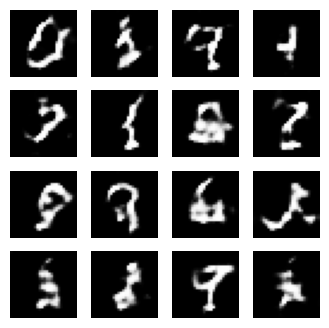

Time for epoch 26 is 13.61 sec


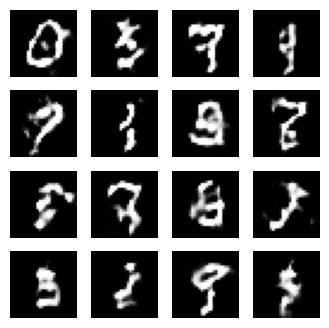

Time for epoch 27 is 13.62 sec


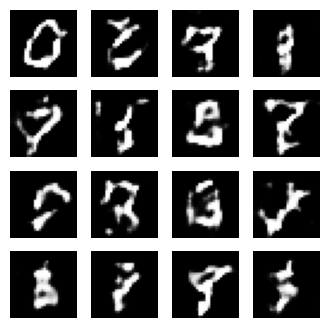

Time for epoch 28 is 13.78 sec


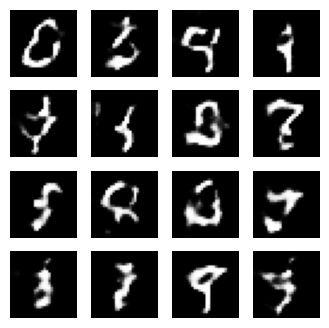

Time for epoch 29 is 13.63 sec


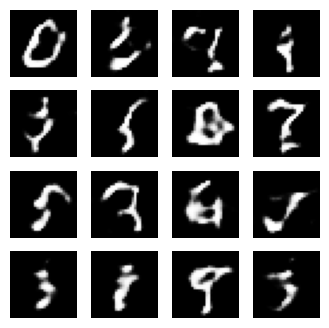

Time for epoch 30 is 13.79 sec


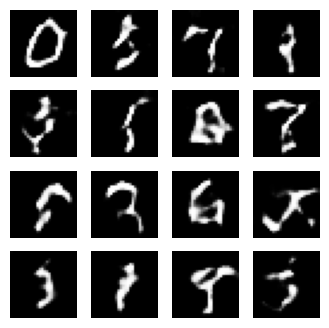

Time for epoch 31 is 13.91 sec


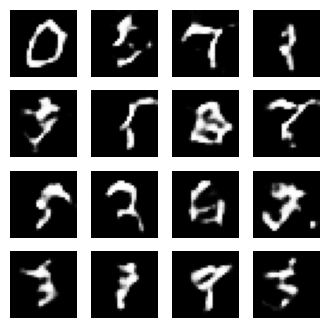

Time for epoch 32 is 13.62 sec


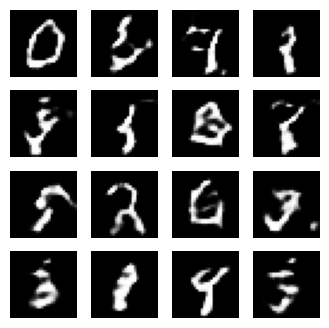

Time for epoch 33 is 13.64 sec


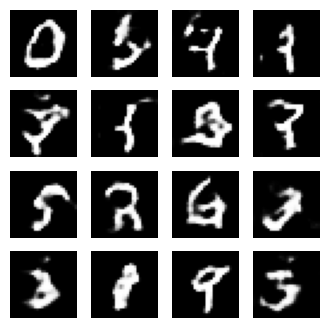

Time for epoch 34 is 13.63 sec


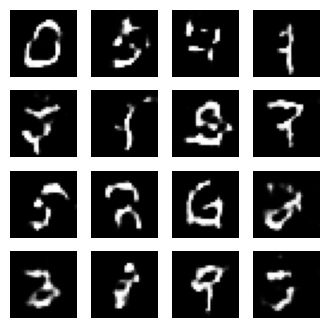

Time for epoch 35 is 13.71 sec


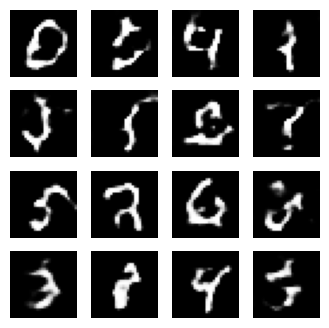

Time for epoch 36 is 13.67 sec


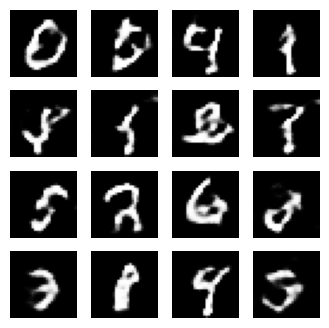

Time for epoch 37 is 13.91 sec


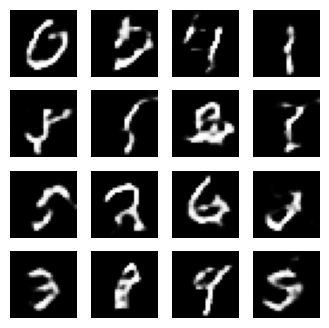

Time for epoch 38 is 13.64 sec


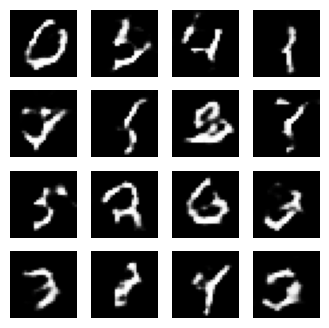

Time for epoch 39 is 13.65 sec


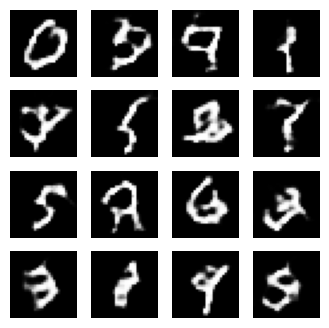

Time for epoch 40 is 13.66 sec


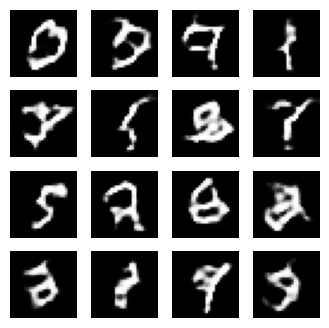

Time for epoch 41 is 13.71 sec


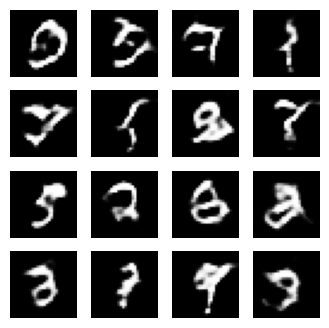

Time for epoch 42 is 14.07 sec


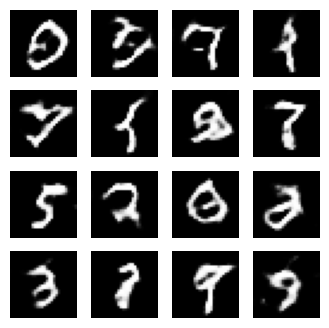

Time for epoch 43 is 13.64 sec


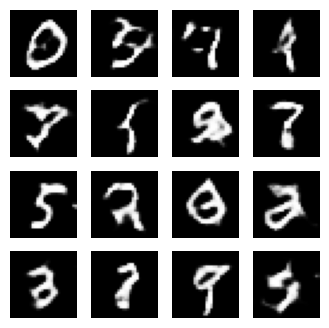

Time for epoch 44 is 13.65 sec


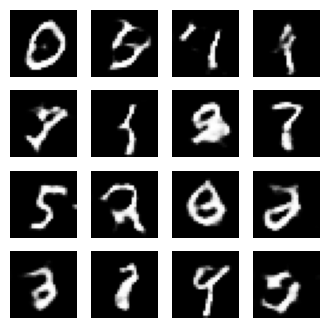

Time for epoch 45 is 13.82 sec


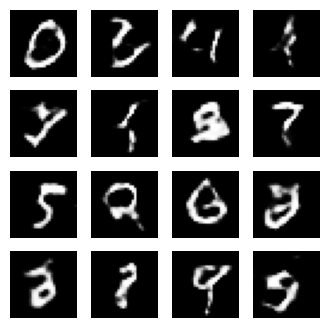

Time for epoch 46 is 13.61 sec


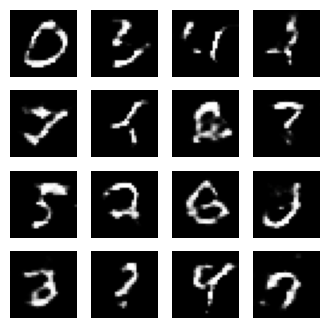

Time for epoch 47 is 13.63 sec


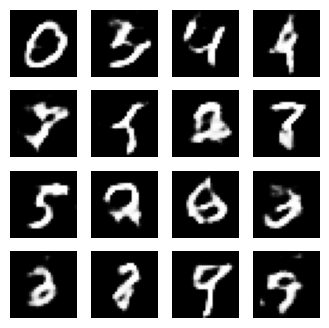

Time for epoch 48 is 13.77 sec


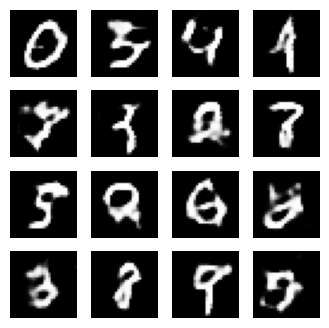

Time for epoch 49 is 13.96 sec


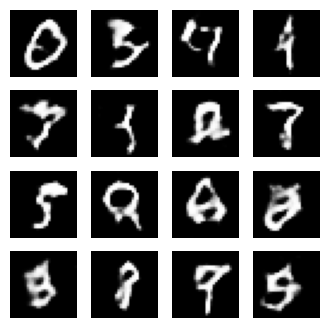

Time for epoch 50 is 13.63 sec


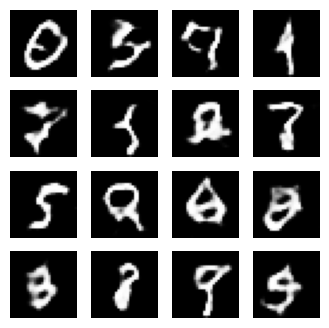

Time for epoch 51 is 13.62 sec


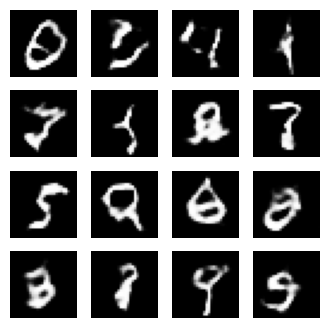

Time for epoch 52 is 13.65 sec


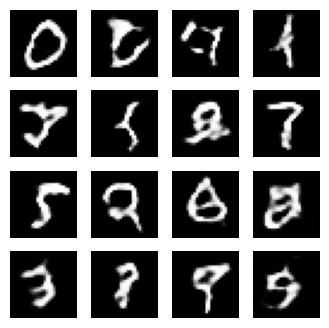

Time for epoch 53 is 13.66 sec


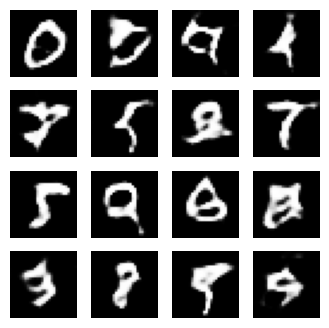

Time for epoch 54 is 13.65 sec


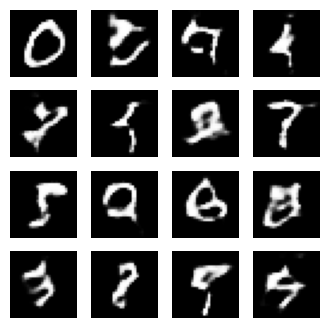

Time for epoch 55 is 14.06 sec


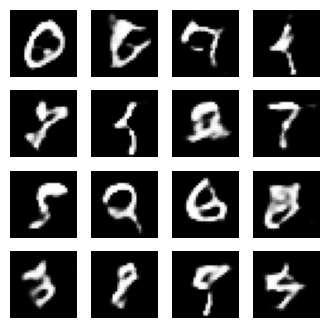

Time for epoch 56 is 13.62 sec


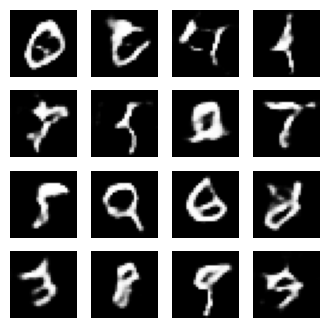

Time for epoch 57 is 13.62 sec


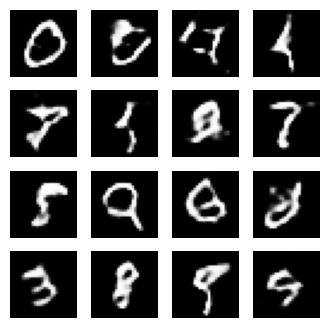

Time for epoch 58 is 13.61 sec


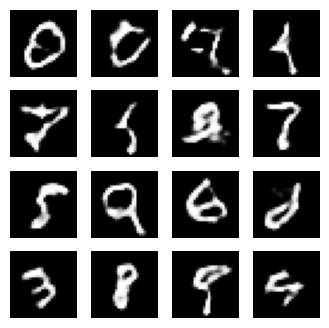

Time for epoch 59 is 13.61 sec


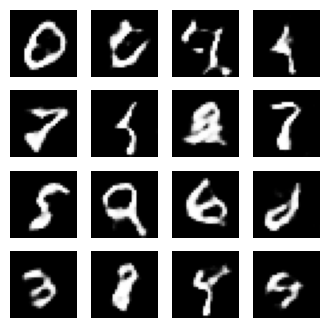

Time for epoch 60 is 14.04 sec


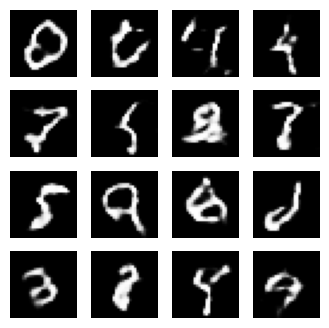

Time for epoch 61 is 13.70 sec


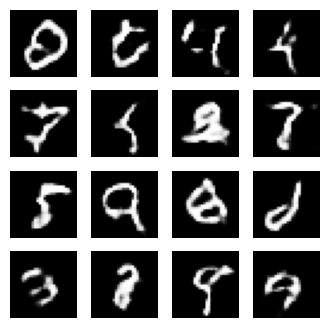

Time for epoch 62 is 13.67 sec


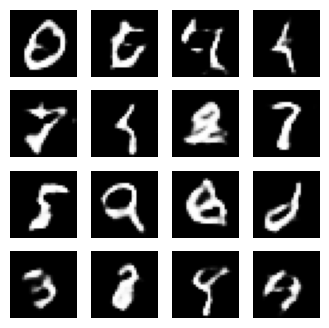

Time for epoch 63 is 13.66 sec


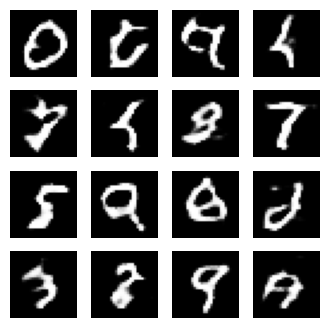

Time for epoch 64 is 13.66 sec


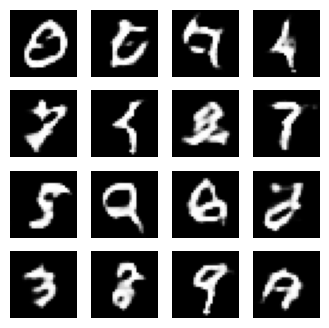

Time for epoch 65 is 13.63 sec


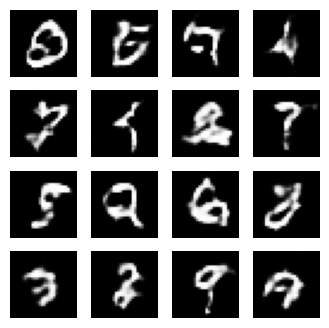

Time for epoch 66 is 13.91 sec


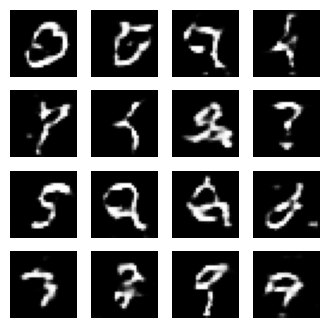

Time for epoch 67 is 13.62 sec


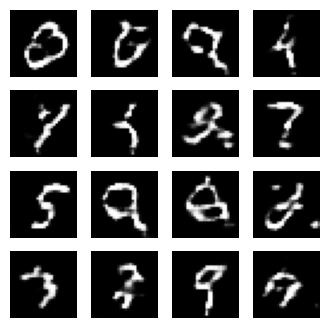

Time for epoch 68 is 13.80 sec


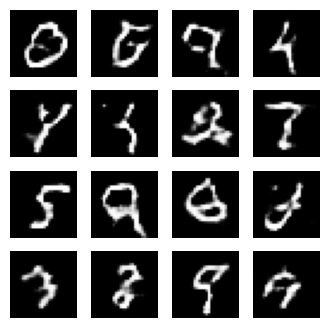

Time for epoch 69 is 13.66 sec


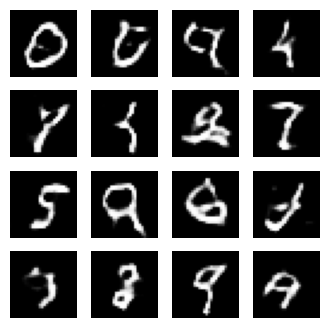

Time for epoch 70 is 13.64 sec


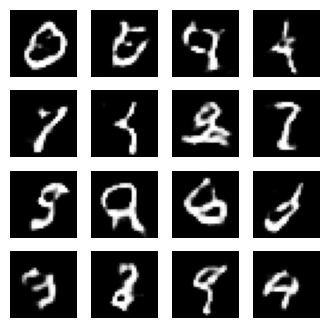

Time for epoch 71 is 13.68 sec


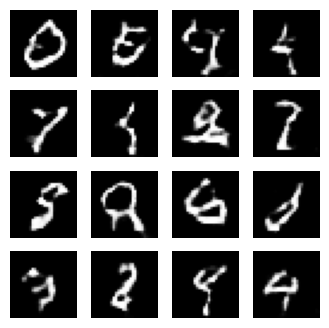

Time for epoch 72 is 13.68 sec


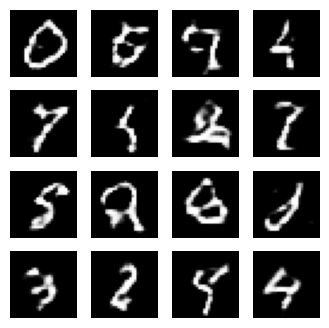

Time for epoch 73 is 13.95 sec


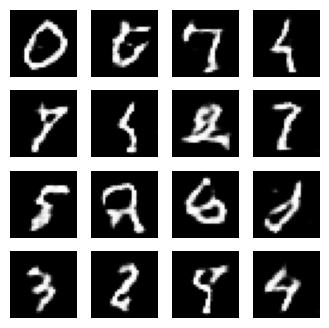

Time for epoch 74 is 13.72 sec


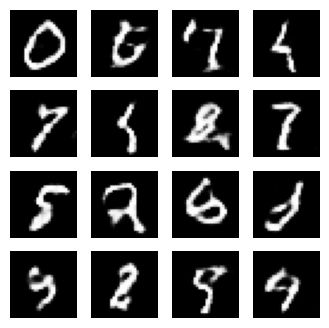

Time for epoch 75 is 13.82 sec


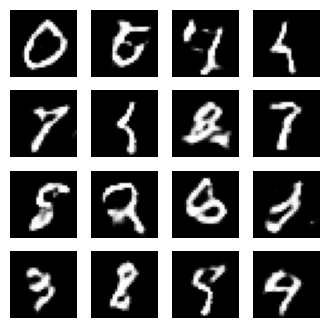

Time for epoch 76 is 13.60 sec


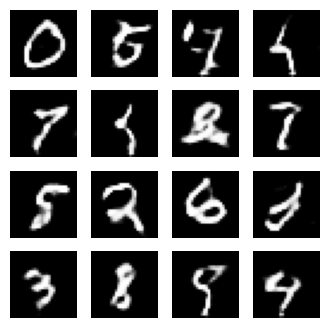

Time for epoch 77 is 13.61 sec


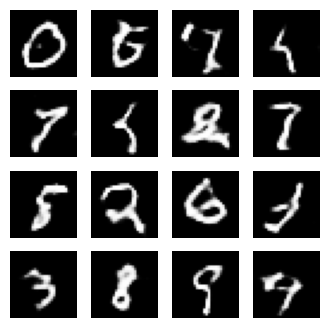

Time for epoch 78 is 13.62 sec


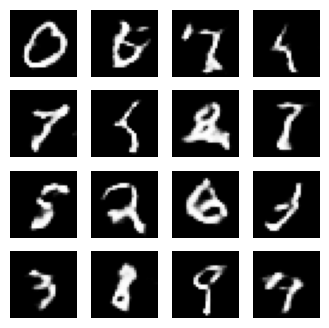

Time for epoch 79 is 13.87 sec


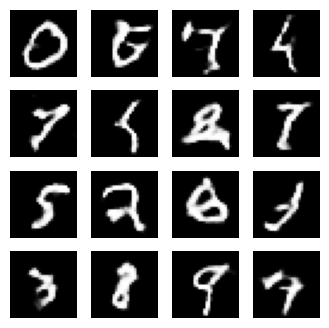

Time for epoch 80 is 13.58 sec


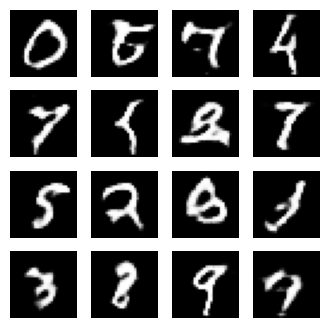

Time for epoch 81 is 13.76 sec


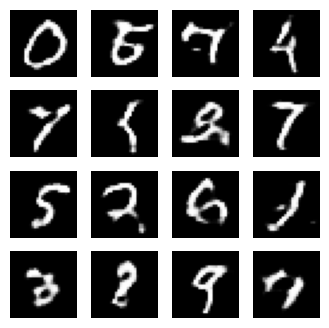

Time for epoch 82 is 13.61 sec


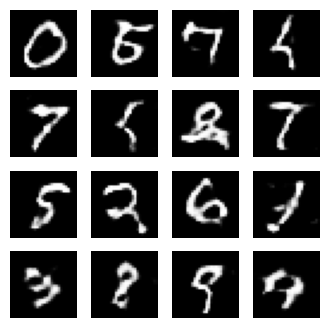

Time for epoch 83 is 13.61 sec


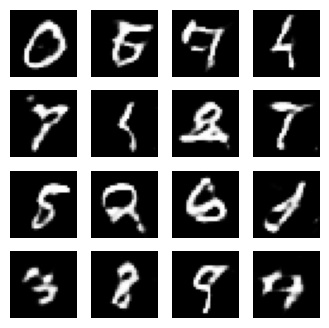

Time for epoch 84 is 14.09 sec


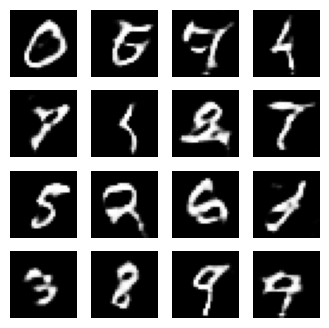

Time for epoch 85 is 13.63 sec


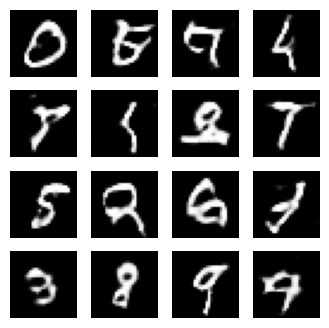

Time for epoch 86 is 13.62 sec


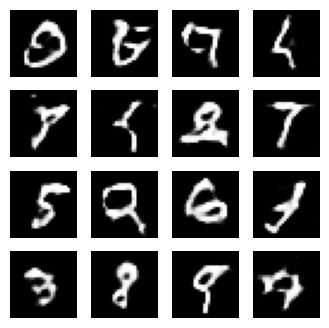

Time for epoch 87 is 13.62 sec


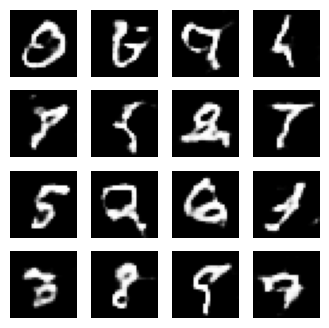

Time for epoch 88 is 13.78 sec


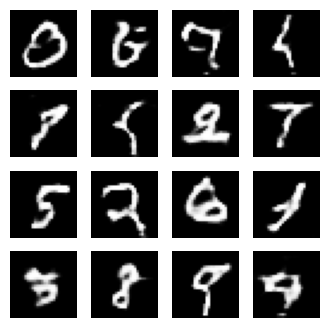

Time for epoch 89 is 13.67 sec


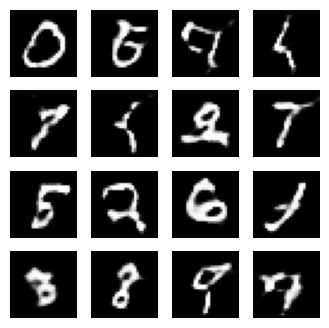

Time for epoch 90 is 13.80 sec


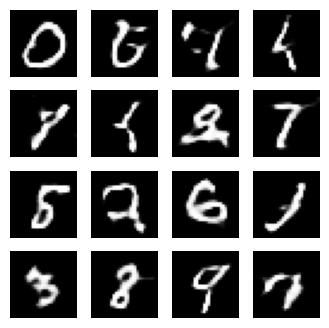

Time for epoch 91 is 13.90 sec


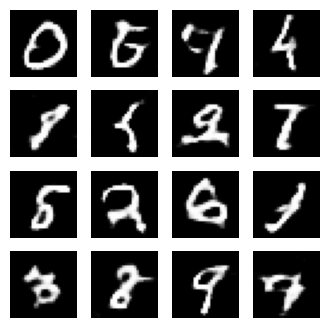

Time for epoch 92 is 13.62 sec


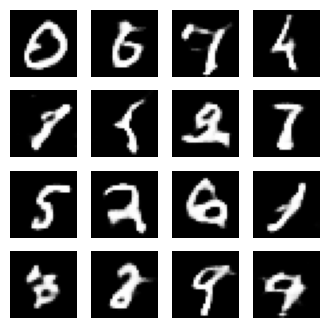

Time for epoch 93 is 13.65 sec


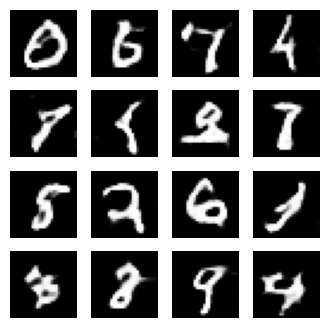

Time for epoch 94 is 13.81 sec


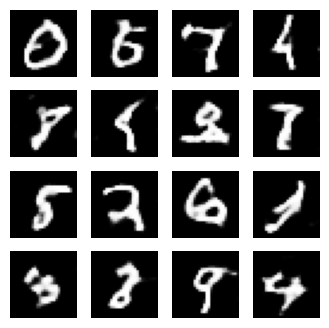

Time for epoch 95 is 13.74 sec


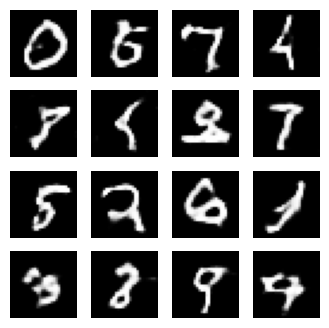

Time for epoch 96 is 13.65 sec


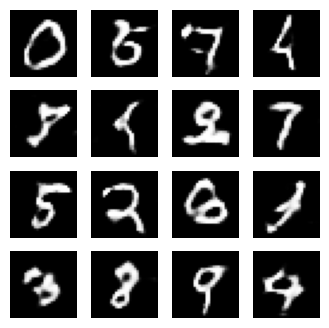

Time for epoch 97 is 13.95 sec


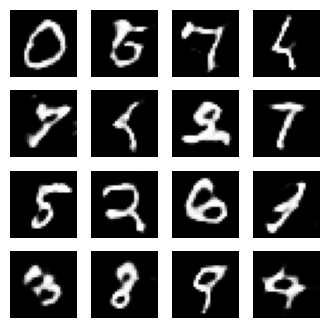

Time for epoch 98 is 13.65 sec


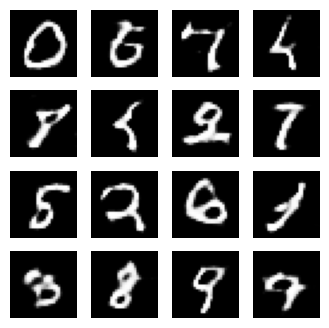

Time for epoch 99 is 13.66 sec


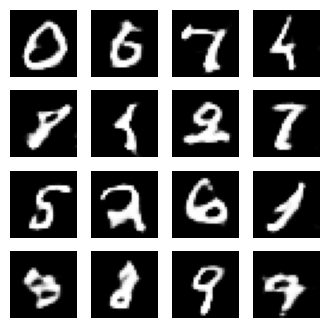

Time for epoch 100 is 13.63 sec


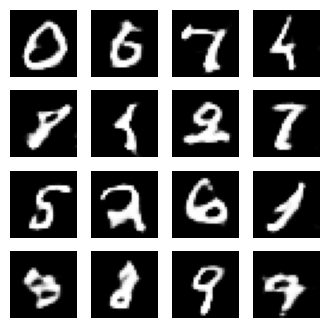

In [22]:
# Function to generate and save images during training
def generate_and_save_images(model, epoch, test_input):
    # Note: Set training=False to ensure that all layers run in inference mode (e.g., dropout and batchnorm)
    predictions = model(test_input, training=False)

    # Rescale images from [-1, 1] to [0, 1] for display
    predictions = (predictions + 1) / 2.0

    # Set up the plot
    fig = plt.figure(figsize=(4, 4))

    # Generate subplots for each image
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # Save the figure
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


# Training function to run the training loop.
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        # Iterate over each batch of images.
        for image_batch in dataset:
            train_step(image_batch)

        # Clear the output to display progress.
        # display.clear_output(wait=True)
        # Generate and save images to visualize progress.
        generate_and_save_images(generator, epoch+1, seed)

        # save the model every 15 epochs.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print("Time for epoch {} is {:.2f} sec".format(epoch + 1, time.time() - start))

    # Generate images after the final epoch.
    # display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

# Start training the GAN
train(train_dataset, EPOCHS)

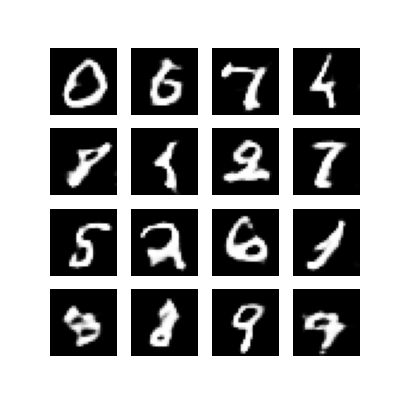

In [23]:
# Restoring the latest checkpoint if needed.
# This can be used to resume training or generate images from a saved model.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Function to display a single image generated after a specific epoch.
def display_image(epoch_no):
    return PIL.Image.open("image_at_epoch_{:04d}.png".format(epoch_no))

# Display the image generated after the final epoch.
display_image(EPOCHS)

In [24]:
# Create an animated GIF of the generated images over epochs
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    # Get the list of image files generated during training
    filenames = glob.glob('image_at_epoch_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    # Append the last image multiple times for a pause at the end
    for _ in range(10):
        writer.append_data(image)

<ipython-input-24-283ca4287b8c>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [25]:
# Save the trained generator model in Keras H5 format
generator.save('generator_model_final.keras')
print("Generator model saved to 'generator_model.h5'")

Generator model saved to 'generator_model.h5'


Generator model loaded successfully.


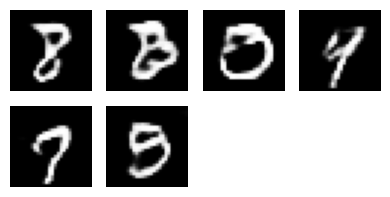

In [26]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the saved generator model
generator_trained = tf.keras.models.load_model('generator_model_final.keras')
print("Generator model loaded successfully.")

# Function to generate and display images
def generate_images(generator, num_images=6, noise_dim=100):
    # Generate random noise vectors
    noise = tf.random.normal([num_images, noise_dim])

    # Generate images using the loaded generator
    generated_images = generator(noise, training=False)

    # Rescale images from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1) / 2.0

    # Plot the generated images
    plt.figure(figsize=(4, 4))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate and display images
generate_images(generator_trained)